# deepSSAM prototype notebook

This notebook contains a prototype implementation of a deepSSAM neural network algorithm that uses a pre-trained neural network to generalize gene expression information to FITC/DAPI technology information.

#### Imports:

In [24]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)


3.144703805446625e-05


#### Parameter definition:

In [26]:
img_path_wall = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_Cellbound3_z4.tif'
img_path_dapi = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_DAPI_z4.tif'
coordinate_path = '/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/detected_transcripts_S1R1.csv'
# analysis/tiesmeys/data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/detected_transcripts_S1R1.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [27]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


In [ ]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

perf_=time.perf_counter()

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(f'Loading time: {time.perf_counter()-perf_}')
perf_=time.perf_counter()


df.columns=['x','y','z','gene']
df = df[~df.gene.str.contains('Blank')]
# df.x-=df.x.min()
# df.y-=df.y.min()
df.x/=um_per_pixel/scale
df.y/=um_per_pixel/scale

df.gene.replace({'Acte1':'Gm498'})

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

print(f'Pre-processing time: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

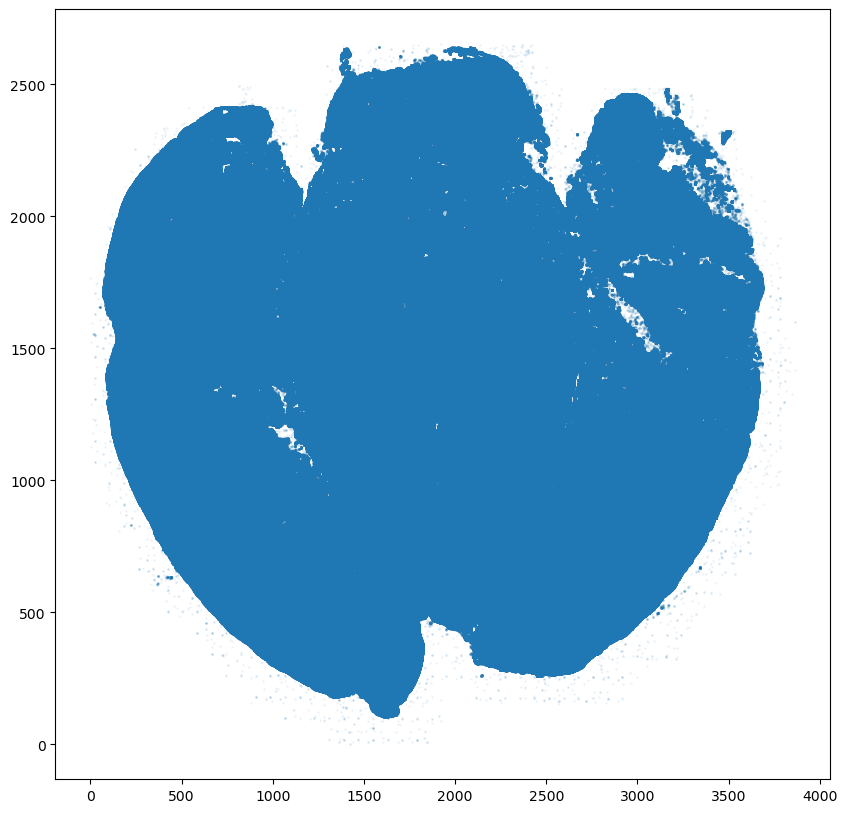

In [6]:
#
plt.figure(figsize=(10,10))

# x_lims = [1700,2100]
# y_lims = [1000,1300]

# df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

# df = df[df_mask].copy()

df.x-=df.x.min()
df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1,alpha=0.05)
df.gene = df.gene.astype('str').astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index



In [10]:
from src import ovrlp

roi_df = ovrlp.find_overlaps(df,threshold_fraction=0.4,density_weight=0.3,min_distance=20)
rois_x, rois_y, divergence, signal, divergence_map = ovrlp.compute_divergence(df, genes, plot=False,
                                            threshold_fraction=0.4,density_weight=0.3,
                                            min_distance=20,return_maps=True)

# _=ovrlp.assign_xy(spot_df_raw)
roi_df = pd.DataFrame({'x':rois_x, 'y':rois_y, 'divergence':divergence})

In [ ]:

from matplotlib.colors import LinearSegmentedColormap


# rois_x, rois_y, divergence, signal, divergence_map = ovrlp.compute_divergence(spot_df_raw, genes, plot=False,
#                                             threshold_fraction=0.4,density_weight=0.3,
#                                             min_distance=20,return_maps=True)

BlGr = LinearSegmentedColormap.from_list('BlGr', ['black','blue'], N=256)
TrRd = LinearSegmentedColormap.from_list('TrRd', [[1.0,1.0,1.0,1.0],[1.0,0.0,0.0,1.0]], N=256)

f, (p, b1,b2) = plt.subplots(1, 3, width_ratios=[23, 1,1],figsize=(11,13))

handle_hist_sum_alpha = (hist_sum>(np.max(hist_sum)/5)).astype(float)
handle_hist_sum = p.imshow(hist_sum,cmap=BlGr,alpha=handle_hist_sum_alpha)
p.set_facecolor('black')

incoherence = divergence_map*hist_sum
incoherence/=incoherence.max()
incoherence_alpha = (incoherence>(np.max(incoherence)/5)).astype(float)
handle_divergence = p.imshow(incoherence,cmap=TrRd,alpha=incoherence_alpha)

plt.colorbar(handle_hist_sum,cax=b1)
plt.colorbar(handle_divergence,cax=b2)

b1.set_title('signal')
b2.set_title('incoherence')


In [ ]:
roi_df.to_csv('output/rois_vizgen_receptor.csv')

In [ ]:
signatures = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures = signatures.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(np.mean).T

signatures = signatures[signatures.index.isin(genes)]

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
# test if signatures.index contains 'Gm498':

signatures

,Astro,CA1,CA2,CA3,CR,CT,Car3,DG,Endo,IT,...,Oligo,Pax6,ProS,Pvalb,SMC,SUB,Sncg,Sst,VLMC,Vip
feature,,,,,,,,,,,,,,,,,,,,,
Oprk1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.019103,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Npbwr1,0.000000,0.275924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Adgrb3,7.671089,10.782383,10.230757,9.752976,1.706938,11.251373,11.026979,10.566449,0.0,10.539905,...,3.438615,9.772122,10.860039,10.678574,0.0,10.712973,10.275768,9.409108,0.000000,10.357043
Gpr45,0.000000,2.846237,2.494493,3.624634,0.000000,1.969430,2.012273,0.523586,0.0,2.787082,...,0.074746,0.000000,2.984208,0.530710,0.0,2.854284,0.596850,1.750719,0.000000,0.746383
Fzd7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.210256,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Htr7,0.000000,0.110040,3.629142,0.086264,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.496985,0.051739,0.000000,0.0,0.000000,1.006448,0.371320,0.000000,0.144282
Ffar4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.007070,0.000000,0.000000
Adra2a,0.000000,0.272689,0.000000,0.326914,0.000000,0.000000,0.717811,0.000000,0.0,0.186745,...,0.000000,0.000000,0.603560,0.000000,0.0,0.000000,0.215321,0.000000,0.632674,0.039534


In [ ]:
vis = ovrlp.Visualizer()

vis.fit(spot_df_raw,signature_matrix=signatures)

In [ ]:
vis.plot_fit()

In [ ]:
assert False

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Plotting case 1


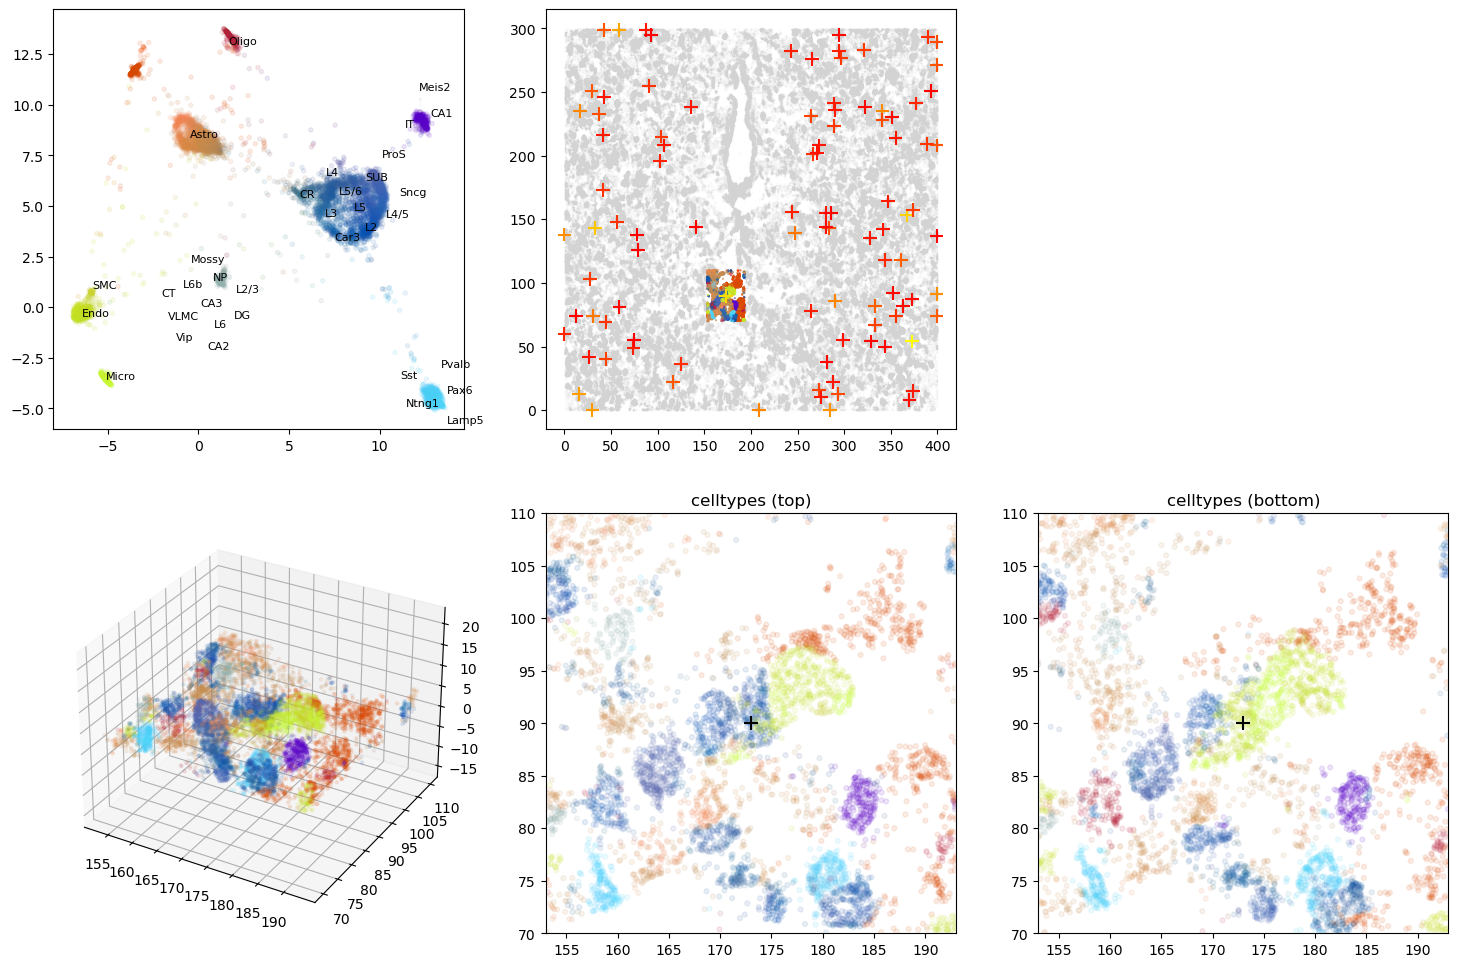

In [ ]:

ovrlp.visualize_rois(df,roi_df, signature_matrix = signatures,
                     celltyping_min_expression=5,
                     n_cases=range(1,2),plot_window_size=20)

In [ ]:
import os
import h5py as h5

os.listdir('../../data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/cell_boundaries')

cell_metadata = pd.read_csv('../../data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/cell_metadata_S1R1.csv',index_col=0)

cell_metadata.head()
# # # open ('../../data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/cell_boundaries/feature_data_563.hdf5')

# # # f = h5.File('../../data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/cell_boundaries/feature_data_563.hdf5', 'r')


# # coords = np.array(f['featuredata']['102393346795905022879352815478289066900']['zIndex_6']['p_0']['coordinates'])


# # plt.plot(*coords[0,:].T)
# # # f['featuredata']['102393346795905022879352815478289066900'].keys()


,fov,volume,center_x,center_y,min_x,max_x,min_y,max_y
110883424764611924400221639916314253469,0,432.141425,156.563284,4271.326432,151.530484,161.596084,4264.619632,4278.033232
135188247894899244046039873973964001182,0,1351.802616,156.509284,4256.962431,148.290484,164.728084,4247.663631,4266.261232
164766962839370328502017156371562646881,0,1080.653268,159.965284,4228.180431,152.178484,167.752084,4220.555630,4235.805231
165747897693809971960756442245389760838,0,1652.000749,167.579284,4323.868433,158.226484,176.932084,4314.191633,4333.545233
260943245639750847364278545493286724628,0,1343.378642,160.559284,4308.802433,152.394484,168.724084,4301.231633,4316.373233


In [ ]:
from sklearn.decomposition import PCA as dim_reduction
import umap


rois_celltyping_x,rois_celltyping_y = ovrlp.get_rois(df, genes = genes, min_distance=8,
                        KDE_bandwidth=1, min_expression=10)


localmax_celltyping_samples =  ovrlp.get_expression_vectors_at_rois(df,rois_celltyping_x,rois_celltyping_y,genes,) 

localmax_celltyping_samples = localmax_celltyping_samples/(localmax_celltyping_samples.to_numpy()**2).sum(0,keepdims=True)**0.5

# print(localmax_celltyping_samples)

dr = dim_reduction(n_components=100)
factors = dr.fit_transform(localmax_celltyping_samples.T)

embedder_2d = umap.UMAP(n_components=2,min_dist=0.0)
embedding = embedder_2d.fit_transform(factors)

embedder_3d = umap.UMAP(n_components=3, min_dist=0.0,n_neighbors=10,
                init=np.concatenate([embedding,0.1*np.random.normal(size=(embedding.shape[0],1))],axis=1))
embedding_color = embedder_3d.fit_transform(embedding)

embedding_color,color_pca = ovrlp.fill_color_axes(embedding_color)

color_min = embedding_color.min(0)
color_max = embedding_color.max(0)

colors = ovrlp.min_to_max(embedding_color.copy())

In [ ]:
celltypes = sorted(signatures.columns)

# gene_intersection = list(set(signature_matrix.index).intersection(set(genes)))
celltype_class_assignments = ovrlp.determine_celltype_class_assignments(localmax_celltyping_samples,signatures)
# print(celltype_class_assignments)
# determine the center of gravity of each celltype in the embedding:
celltype_centers = np.array([np.median(embedding[celltype_class_assignments==i,:],axis=0) for i in range(len(celltypes))])


In [ ]:
n_roi = 0

x,y = roi_df.x.iloc[n_roi],roi_df.y.iloc[n_roi]

# ct_top,ct_bottom = get_celltype(expressions_top.iloc[idcs[n_case]]),get_celltype(expressions_bottom.iloc[idcs[n_case]])

# print("Plotting case {}".format(n_case))

subsample_mask = ovrlp.get_spatial_subsample_mask(df,x,y,plot_window_size=40)
subsample = df[subsample_mask]

distances, neighbor_indices = ovrlp.create_knn_graph(subsample[['x','y','z']].values,k=90)
local_expression = ovrlp.get_knn_expression(distances,neighbor_indices,genes,subsample.gene.cat.codes.values,bandwidth=1.5)
local_expression = local_expression/((local_expression**2).sum(0)**0.5)
subsample_embedding, subsample_embedding_color = ovrlp.transform_embeddings(local_expression.T.values,dr,embedder_2d=embedder_2d,embedder_3d=embedder_3d)
subsample_embedding_color,_ = ovrlp.fill_color_axes(subsample_embedding_color,color_pca)
subsample_embedding_color = (subsample_embedding_color-color_min)/(color_max-color_min)
subsample_embedding_color = np.clip(subsample_embedding_color,0,1)

(-40.0, 40.0)

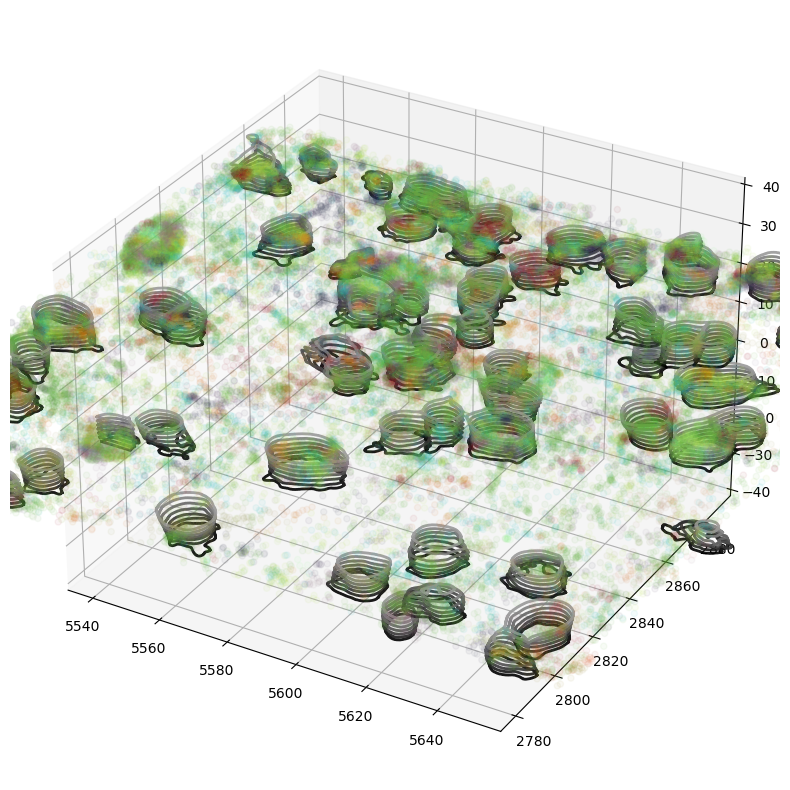

In [ ]:

x_ = roi_df.x.iloc[n_roi]*um_per_pixel
y_ = roi_df.y.iloc[n_roi]*um_per_pixel

close_cells = cell_metadata[((cell_metadata.center_x-x_).abs()<100) & ((cell_metadata.center_y-y_).abs()<100)]
fov = close_cells.fov.value_counts().index[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(subsample.x*um_per_pixel,subsample.y*um_per_pixel,subsample.z,c=subsample_embedding_color,marker='o',alpha=0.05)



for close_cell in close_cells.index:

    fov = (close_cells.loc[close_cell,'fov'])
    f = h5.File(f'../../data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/cell_boundaries/feature_data_{fov}.hdf5', 'r')

    for index in range(7):
        if 'p_0' in f['featuredata'][f'{close_cell}'][f'zIndex_{index}'].keys():
            outlines = np.array(f['featuredata'][f'{close_cell}'][f'zIndex_{index}']['p_0']['coordinates'])
            ax.plot(*outlines.T,np.zeros((outlines.shape[0],))+index,c=[index/10,index/10,(index/10)],alpha=0.9,linewidth=2,zorder=1)



ax.set_xlim(x_-60,x_+60)
ax.set_ylim(y_-60,y_+60)
ax.set_zlim(-40,40)



(2775.0, 2895.0)

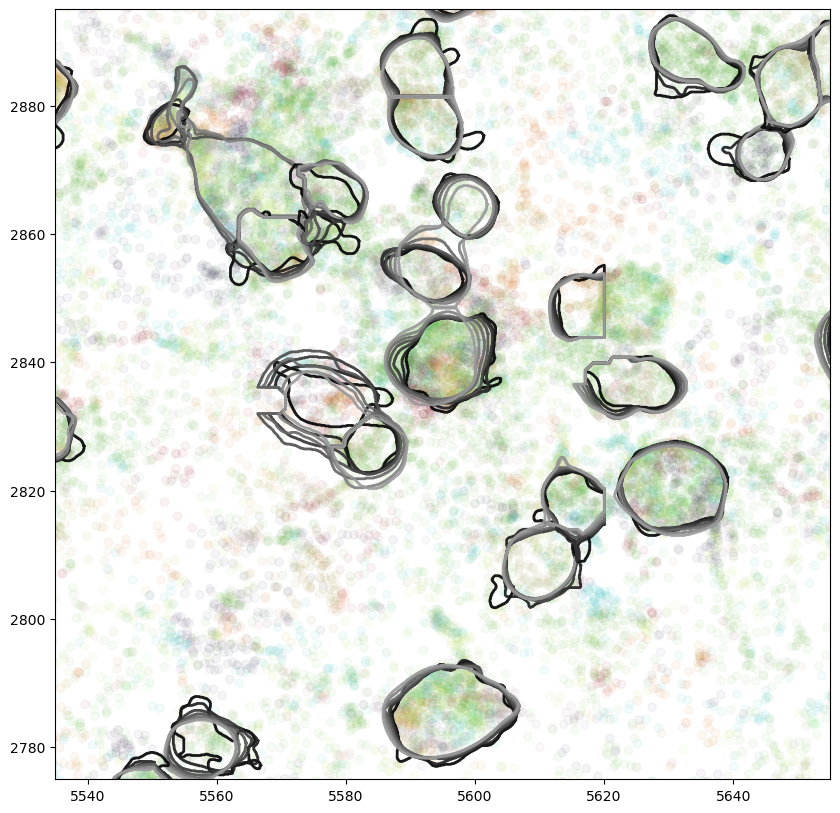

In [ ]:

x_ = roi_df.x.iloc[n_roi]*um_per_pixel
y_ = roi_df.y.iloc[n_roi]*um_per_pixel

close_cells = cell_metadata[((cell_metadata.center_x-x_).abs()<100) & ((cell_metadata.center_y-y_).abs()<100)]
fov = close_cells.fov.value_counts().index[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(subsample.x*um_per_pixel,subsample.y*um_per_pixel,c=subsample_embedding_color,marker='o',alpha=0.1)



for close_cell in close_cells.index:

    fov = (close_cells.loc[close_cell,'fov'])
    f = h5.File(f'../../data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/cell_boundaries/feature_data_{fov}.hdf5', 'r')

    for index in range(7):
        if 'p_0' in f['featuredata'][f'{close_cell}'][f'zIndex_{index}'].keys():
            outlines = np.array(f['featuredata'][f'{close_cell}'][f'zIndex_{index}']['p_0']['coordinates'])
            ax.plot(*outlines.T,c=[index/10,index/10,(index/10)],alpha=0.9,linewidth=2,zorder=1)



ax.set_xlim(x_-60,x_+60)
ax.set_ylim(y_-60,y_+60)
# ax.set_zlim(-40,40)



In [ ]:

# # We assign each spot to the nearest celltype, using an annotated single-cell dataset:

# # Load the single-cell dataset:
# adata_snrna = anndata.read_h5ad('../../data/z-incoherence/counts_CPn_exp0.h5ad')
# adata_snrna = adata_snrna[:,adata_snrna.var.index.isin(genes)]
# adata_snrna.obs = adata_snrna.obs[['celltype']]

# # Load the single-cell dataset:
# adata_scrna = anndata.read_h5ad('../../data/z-incoherence/counts_WS_blur5_exp0.h5ad')
# adata_scrna = adata_scrna[:,adata_scrna.var.index.isin(genes)]
# adata_scrna.obs = adata_scrna.obs[['celltype']]

# # adata_sncrna = anndata.concat([adata_snrna,adata_scrna],axis=0,join='outer')
# adata_sncrna.obs['celltype_coarse'] = adata_sncrna.obs.celltype.apply(lambda x: x.split(' ')[0])

# adata_sncrna.obs.index = ('Cell_'+pd.Series(np.arange(adata_sncrna.shape[0])).astype(str)).values

# del adata_snrna,adata_scrna

# # define a signature matrix of mean celltype expression profiles:
# celltypes = sorted(adata_sncrna.obs.celltype_coarse.unique())
# gene_intersection = (pd.Series(genes)[pd.Series(genes).isin(adata_sncrna.var.index).values]).values
# signatures = pd.DataFrame(index=gene_intersection,columns=celltypes)

# # fill the signatures with mean expression values:
# for celltype in signatures.columns:
#     subset = adata_sncrna.X[adata_sncrna.obs.celltype_coarse==celltype,:]
#     subset = pd.Series(np.nan_to_num(subset).mean(0),
#                        index=adata_sncrna.var.index)

#     signatures[celltype] = subset[gene_intersection].values / (subset.sum()+1)

# signatures

In [ ]:
outlines.shape[1]

295

#### Loading image data:

In [ ]:

from PIL import Image

Image.MAX_IMAGE_PIXELS =10e10

img_=Image.open(img_path_wall)#[:4000,:4000]
img_=(np.array(img_.resize((np.array(img_.size)*scale).astype(int)),)[...,None]/256).astype("uint8")
print(img_.max())

img_ = np.concatenate((np.zeros_like(img_),img_, (np.array(Image.open(img_path_dapi).resize(img_.shape[1::-1]))[...,None]/256).astype("uint8")),axis=-1,dtype='uint8')
# img_ = img_[:2000,:2000]

img=img_.copy()
# img = np.array(img)

# del img_

plt.imshow(img_)

FileNotFoundError: [Errno 2] No such file or directory: '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_Cellbound3_z4.tif'

#### Apply spatial equalizer to the image. 

In [ ]:

from scipy import ndimage

img=img_.copy()

# walls_hpf = np.fft.ifft2(ndimage.fourier_gaussian(np.fft.fft2(img_[:,:,1]), sigma=100)).real
# walls_hpf = img_[:,:,1]/(walls_hpf+0.1)
# walls_hpf=walls_hpf**0.8
# walls_hpf/=walls_hpf.max()/4000
# walls_hpf[walls_hpf>256]=255
# img[:,:,1]= (walls_hpf).astype("uint8")

# dapi_hpf = np.fft.ifft2(ndimage.fourier_gaussian(np.fft.fft2(img_[:,:,2]), sigma=100)).real
# dapi_hpf = img_[:,:,2]/(dapi_hpf+0.1)
# dapi_hpf = dapi_hpf**0.8
# dapi_hpf/=dapi_hpf.max()/3000
# dapi_hpf[dapi_hpf>256]=255
# img[:,:,2]= (dapi_hpf).astype("uint8")

img = img.transpose((1,0,2))

del img_

In [ ]:
# img_val = img[img.shape[1]:,:img.shape[1]]
# img_train =  img[:img.shape[1],:img.shape[1]]

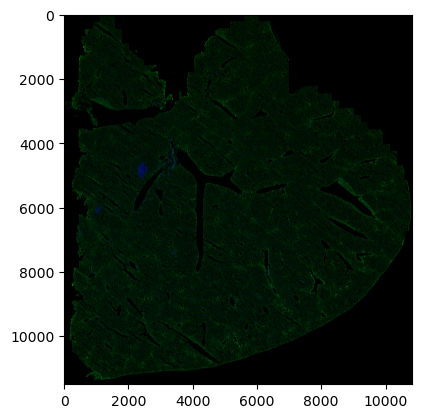

In [ ]:
plt.figure()
plt.imshow(img)